# DELE ST1504 CA2
# PART A: GAN

<hr>

**NAME**: Irman Zafyree, Adam Tan

**ADMIN NO**: `2300546`, `2300575`

**CLASS**: DAAA/FT/2B/07

<hr>

**Objective:**

Code a GAN model that is able to generate 260 small black-and-white images of the given dataset in 26 distinct classes.

**Background:**
A Generative Adversarial Network (GAN) is a type of deep learning model consisting of two neural networks: a generator and a discriminator. The primary purpose of a GAN is to generate new data instances that resemble the training data, through a competitive process between a generator and a discriminator. It has revolutionized the field of generative modeling and continues to be a vibrant area of research and application in artificial intelligence.





# Initial Set Up

In [ ]:
# Basic imports
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from IPython import display

# Tensorflow imports
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.metrics import Mean
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Dense, Reshape, Conv2D, LeakyReLU, Dropout, Flatten, Conv2DTranspose, BatchNormalization
from tensorflow.train import Checkpoint
from tensorflow.keras import layers

load_dotenv()

dataset_path = os.environ.get("DATASET_PATH")

print(dataset_path)

In [ ]:

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print(tf.config.experimental.get_device_details(gpu))
    tf.config.experimental.set_memory_growth(gpu, True)
print(f"There are {len(gpus)} GPUs")

In [ ]:
df = pd.read_csv(dataset_path, header=None)
df

In [ ]:
df.isnull().sum()

Background Research

**CSV Dataset:**
- the datatset consists of 99040 datasets
- the first column represents the classs labels -1 to 26.
- Remaining 784 columns are the pixel data

**Classes:**

Total of 27 distinct classes 
1. -1 (all black)
2. 1 (a)
3. 2 (b)
4. 3 (c)
5. 4 (d)
6. 5 (e)
7. 6 (f)
8. 7 (g)
9. 8 (h)
10. 9 (i)
11. 10 (j)
12. 11 (k)
13. 12 (l)
14. 13 (m)
15. 14 (n)
16. 15 (o)
17. 16 (p)
18. 17 (q)
19. 18 (r)
20. 19 (s)
21. 20 (t)
22. 21 (u)
23. 22 (v)
24. 23 (w)
25. 24 (x)
26. 25 (y)
27. 26 (z)


**Images:**

The images are of size 28x28

In [ ]:
labels = df[0]

In [ ]:
data = df.drop(df.columns[0], axis=1)
data.head()

In [ ]:

# Function to display images
def display_images(images, label):
    plt.figure(figsize=(20, 4))
    for index, image in enumerate(images[:20]):
        plt.subplot(1, 20, index + 1)
        image = np.array(image).reshape(28, 28)
        rotated_image = np.rot90(image, k=-1)  
        flipped_horizontal = np.fliplr(rotated_image)
        plt.imshow(flipped_horizontal, cmap='gray')
        plt.axis('off')
        plt.title(f"{label}")

# Order labels from -1 to 26
ordered_labels = sorted(labels.unique(), key=lambda x: (x != -1, x))

# Iterate through each ordered label and display 10 images
for label in ordered_labels:
    label_images = data[labels == label].values
    display_images(label_images, label)
    plt.show()

In [ ]:
import numpy as np

# Count occurrences of each label
unique_labels, label_counts = np.unique(labels, return_counts=True)

# Print the distribution
print("Class distribution:")
for label, count in zip(unique_labels, label_counts):
    print(f"Label {label}: {count} instances")

plt.figure(figsize=(8, 6))  # Specify the figure size (optional)
plt.bar(unique_labels, label_counts, color='skyblue')

# Customize the chart
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.grid(True)  # Add gridlines for better readability (optional)

# Display the chart
plt.show()

In [ ]:
df = df[df[0] != -1]
df.reset_index(inplace=True)

In [ ]:
df_labels = df[0]
df_data = df.drop(df.columns[0:2], axis=1)
df_data.head()

In [ ]:
augmented_data = df_data.copy()
for i in augmented_data.index:
    pixels = augmented_data.loc[i].values
    image = np.array(pixels).reshape(28, 28)
    rotated_image = np.rot90(image, k=-1)  
    flipped_horizontal = np.fliplr(rotated_image)
    augmented_data.loc[i] = flipped_horizontal.flatten()

In [ ]:
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(np.array(augmented_data.loc[i]).reshape(28, 28), cmap='gray')

In [ ]:
def average_images_per_class(data, labels):

    avg_image_df = pd.DataFrame()

    # average image
    for class_name, group in data.groupby(labels):
        avg_image = group.mean()
        avg_image_df[class_name] = avg_image

    # Create a col of subplots
    fig, axes = plt.subplots(5, 6, figsize=(20, 15))
    for ax, (class_name, avg_image) in zip(axes.flatten(), avg_image_df.items()):
        # image = avg_image.reshape(28, 28)
        # rotated_image = np.rot90(image, k=-1)  
        # flipped_horizontal = np.fliplr(rotated_image)
        # ax.imshow(flipped_horizontal, cmap='gray')
        # ax.set_title(f"Average image for {class_name}")
        # ax.axis('off')  # Turn off axis

        ax.imshow(np.array(avg_image).reshape(28, 28), cmap='gray')
        ax.set_title(f"Average image for {class_name}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

average_images_per_class(augmented_data, df_labels)


# Model Research

From researching online, there seem to be 3 GAN Variations, Deep Convolutional GAN (DCGAN), Conditional GAN (CGAN), Wasserstein GAN (WGAN).

### Deep Convolutional GAN (DCGAN)

DCGANs use deep convolutional neural networks to learn the features of the input data, which allows them to generate high-resolution images that are similar to the training data. The generator network in a DCGAN typically consists of transposed convolutional layers, while the discriminator network consists of convolutional layers. The use of convolutional layers allows DCGANs to take advantage of the spatial relationships in the input data, which results in high-quality generated images.

### Conditional GAN (CGAN)

CGANs that allow the user to control the generated data by adding an additional input to the generator network. This input specifies the desired characteristics of the generated data, such as the color or shape of an image. CGANs can be thought of as a combination of a GAN and a conditional generative model, where the generator and discriminator are trained to take into account both the input data and the condition. This allows CGANs to generate data that is more in line with the user’s expectations.

### Wasserstein GAN (WGAN)

WGANs address some of the stability issues that are commonly encountered when training GANs. WGANs use the Wasserstein distance metric to evaluate the quality of the generated data, which has been shown to provide improved stability during training compared to other metrics. The Wasserstein distance metric measures the earth mover’s distance between the generated data and the training data, which provides a robust measure of the quality of the generated data. WGANs have been shown to be particularly effective for generating high-quality images.

We will be using all these 3 GAN and compare them

# Initial Modelling

## Background on GAN

A generative adversarial network (GAN) has two parts:
- Generator
  - learns to create "real" data
  - generated data becomes the fake training examples
- Discriminator
  - distinguish between real and fake data
  - penalizes the generator if discriminator detects the fake generated data

When the training begins, the generator fake data is easily detectable by the discriminator. However, if the generator training goes well, the fake data becomes indistinguishable to the discriminator.

Below is an example of how the generator improves over time:
1. ![Beginning](https://developers.google.com/static/machine-learning/gan/images/bad_gan.svg)
2. ![Middle](https://developers.google.com/static/machine-learning/gan/images/ok_gan.svg)
3. ![End](https://developers.google.com/static/machine-learning/gan/images/good_gan.svg)

So this is how the entire system will look.
![Entire GAN system](https://developers.google.com/static/machine-learning/gan/images/gan_diagram.svg)

### Discriminator
The main goal of the discriminator is to distinguish real data from the fake generated data. It could use any network architecture appropriate to the type of data it's classifying.

The discriminator training data come from 2 sources.
- Real data comes from the initial dataset that you would like to generate like, in this case, it would be out `emnist-letter.csv`
- Fake data comes from the generator.

The discriminator trains by:
1. Classifying real and fake
2. The loss penalizes the discriminator for misclassifying
3. The discriminator updates it weights through backpropagation

### Generator
The main goal of the generator is to trick the discriminator into thinking it fake data is real.

The generator has a random input. It is usually random noise, and the generator turns the noise into meaningful data. Experiments suggest that the distribution of the noise doesn't matter much, so we can choose something that's easy to sample from, like a uniform distribution.

The generators trains by:
1. Sample noise
2. Produce output
3. Get discriminator to classify
4. Get the loss from the discriminator
5. Backpropagate through the generator network
6. Updates the weight

## Set Up Functions

In [49]:
class DCGAN:
    def __init__(self, noise_dim, BATCH_SIZE, input_shape=(28, 28, 1)):
        self.noise_dim = noise_dim
        self.BATCH_SIZE = BATCH_SIZE
        self.input_shape = input_shape
        self.generator = self.make_generator_model()
        self.discriminator = self.make_discriminator_model()
        self.generator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)
        self.checkpoint_dir = './training_checkpoints'
        self.checkpoint_prefix = os.path.join(self.checkpoint_dir, "ckpt")
        self.checkpoint = tf.train.Checkpoint(generator_optimizer=self.generator_optimizer,
                                              discriminator_optimizer=self.discriminator_optimizer,
                                              generator=self.generator,
                                              discriminator=self.discriminator)
        self.num_examples_to_generate = 16
        self.seed = tf.random.normal([self.num_examples_to_generate, noise_dim])
        self.logs = {
            "generator_loss": [],
            "discriminator_loss": [],
            "KL_divergence": [],
        }

    def make_generator_model(self):
        model = Sequential(name='Generator')
        model.add(Dense(128 * 7 * 7, activation="relu", input_shape=(self.noise_dim,)))
        model.add(Reshape((7, 7, 128)))
        # upsample from 7*7 to 14*14
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        # upsample to 28x28
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(1, kernel_size=7, padding="same", activation='sigmoid'))

        return model

    def make_discriminator_model(self):
        model = Sequential(name='Discriminator')
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same", input_shape=self.input_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        
        return model

    def discriminator_loss(self, real_output, fake_output):
        real_loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(real_output), real_output)
        fake_loss = tf.keras.losses.BinaryCrossentropy()(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    def generator_loss(self, fake_output):
        return tf.keras.losses.BinaryCrossentropy()(tf.ones_like(fake_output), fake_output)

    def kl_divergence(self, p, q):
        return tf.reduce_sum(p * tf.math.log(p/q))

    @tf.function
    def train_step(self, images):
        noise = tf.random.normal([self.BATCH_SIZE, self.noise_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

        self.logs["generator_loss"].append(gen_loss)
        self.logs["discriminator_loss"].append(disc_loss)

        kl_divergence = self.kl_divergence(real_output, fake_output)
        self.logs["KL_divergence"].append(kl_divergence)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

    def train(self, dataset, epochs):
        for epoch in range(epochs):
            for image_batch in tqdm(dataset, desc=f'Epoch {epoch + 1}/{epochs}'):
                self.train_step(image_batch)

            # Produce images for the GIF as we go
            display.clear_output(wait=True)
            self.generate_and_save_images(epoch + 1, self.seed)

            # Save the model every 15 epochs
            if (epoch + 1) % 15 == 0:
                self.checkpoint.save(file_prefix = self.checkpoint_prefix)

        # Generate after the final epoch
        display.clear_output(wait=True)
        self.generate_and_save_images(epochs, self.seed)
        self.generate_plots()

    def generate_plots(self):
        plt.figure(figsize=(20, 5))
        plt.subplot(1, 3, 1)
        plt.plot(self.logs["generator_loss"], label="Generator Loss")
        plt.plot(self.logs["discriminator_loss"], label="Discriminator Loss")
        plt.title("Losses")
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(self.logs["KL_divergence"], label="KL Divergence")
        plt.title("KL Divergence")
        plt.legend()

        plt.show()

    def generate_and_save_images(self, epoch, test_input):
        predictions = self.generator(test_input, training=False)

        fig = plt.figure(figsize=(4, 4))

        for i in range(predictions.shape[0]):
            plt.subplot(4, 4, i+1)
            plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
            plt.axis('off')

        imageDir = './images'
        if not os.path.exists(imageDir):
            os.makedirs(imageDir)
        imagePath = os.path.join(imageDir, 'image_at_epoch_{:04d}.png'.format(epoch))
        plt.savefig(imagePath)
        plt.show()

## Set Up Dataset

In [36]:
df = pd.read_csv(dataset_path, header=None)

train_labels = df[0]
train_data = df.drop(0, axis=1)
augmented_data = []
for i in train_data.index:
    pixels = train_data.loc[i].values
    image = np.array(pixels).reshape(28,28)
    rotated_image = np.rot90(image, k=-1)
    flipped_horizontal = np.fliplr(rotated_image)
    augmented_data.append(flipped_horizontal)

train_data = np.array(augmented_data)
train_data = train_data.reshape(train_data.shape[0], 28, 28, 1).astype('float32')
train_data = (train_data - 127.5) / 127.5 # Normalize the images to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

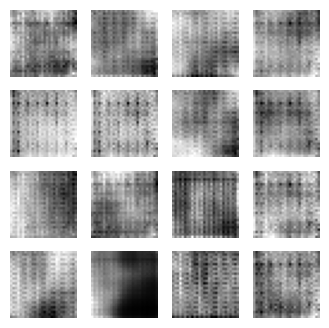

In [47]:
dcgan = DCGAN(100, BATCH_SIZE, (28, 28, 1))
dcgan.train(train_dataset, 50)

# Evaluation

Firstly, evaluating GAN model is hard. Unlike classification, we need to compare the generated image to a real image. But how exactly can you compare/quantify the realism of the generated image.

The main 2 evaluation metrics for GAN models is:
- **Fidelity**: Our GAN should generate _high_ quality images
- **Diversity**: Our GAN should generate images that are inherent in the training dataset

There are 2 approaches to compare the images:
- **Pixel Distance**: The naive distance measure where we just subtract the two images' pixel value. However this approach is not reliable
- **Feature Distance**: We use a pre-trained image classfication model and use the activation of an intermediate layer. This vector is a high level representation of our image. Computing the distancee mtric with the representation gives a stable and reliable result.

## Fretchet Inception Distance (FID)
This is one of the popular metrics to measure the feature distance. Frechet Distance is a measure of similarity between curves that takes into account the location and ordering of the points along the curves. 